DC Resistivity Forward Modeling: Sounding Data over 2D Earth
=======================================

In this notebook, we predict data for a Schlumberger sounding survey over 2D Earth. We need to account for horizontal variations in electrical resistivity by modeling the physics in 2.5. By shifting the center location of the sounding survey, we can predict the sounding data at different locations along the geological cross-section shown below. 

<img style="float: center; width: 800px" src="https://github.com/simpeg-research/gwb-dc-inversions/blob/master/figures/geologic_cross_section.PNG?raw=true">




Import Modules
----------------------

In [20]:
from discretize import TensorMesh
from discretize.utils import mkvc, refine_tree_xyz
import pandas as pd

from SimPEG.utils import ModelBuilder, surface2ind_topo
from SimPEG import maps, data
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static import induced_polarization as ip
from SimPEG.electromagnetics.static.utils import (
        generate_dcip_survey_line, plot_pseudoSection, gettopoCC, source_receiver_midpoints, geometric_factor
        )

import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

User Defined Parameters for the Notebook
---------------------------------------------------------------

Here, the user defines the parameters required to run the notebook. The parameters are as follows:

**Parameters for the survey**

- **half_AB_separation:** a numpy array containing the AB/2 values for the source electrodes
- **half_MN_separations:** a numpy array containing the MN/2 values for the receiver electrodes
- **center_location:** center location for the sounding survey

**Parameters for layer resistivities**

- **alluvium_resistivity:** resistivity for the alluvial layer (range?)
- **sand_aquifer_resistivity:** resistivity for the near-surface sand aquifer (range?)
- **clay_resistivity:** resistivity for the clay/laterite layer (range?)
- **bedrock_resistivity:** resistivity for the bedrock layer (range?)
- **bedrock_aquifer_resistivity:** resistivity for the fractured bedrock aquifer (range?)

In [21]:
# SURVEY PARAMETERS

# Make a numpy array for AB/2 values
half_AB_separation = np.r_[
    5,10,20,30,40,
    40,50,60,70,80,90,100,
    100,120,140,160,180,200,
    200,220,240,260,280,300,
    300,320,350,370,400
]  # AB/2 values

# Make a numpy array for MN/s values
half_MN_separation = np.r_[
    1,1,1,1,1,
    5,5,5,5,5,5,5,
    10,10,10,10,10,10,
    20,20,20,20,20,20,
    30,30,30,30,30
]  # MN/2 values

# Center location for the sounding survey
center_location = 200  

# LAYER RESISTIVITIES (Ohm-meters)
alluvium_resistivity = 400.
sand_aquifer_resistivity = 50.
clay_resistivity = 200
bedrock_resistivity = 2000.
bedrock_aquifer_resistivity = 20.

# Output file name
filename = 'assets/Mon2.5D_synthetic.csv'

Define the Survey
-------------------------

This portion of the notebook defines a Schlumberger sounding survey using the AB/2 values, MN/2 values and center location provided.

In [22]:
source_list = []  # create empty array for sources to live

for ii in range(0, len(half_AB_separation)):
    
    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[center_location-half_AB_separation[ii], 0.]
    B_location = np.r_[center_location+half_AB_separation[ii], 0.]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[center_location-half_MN_separation[ii], 0.]
    N_location = np.r_[center_location+half_MN_separation[ii], 0.]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole_ky(
            M_location, N_location#, data_type='apparent_resistivity'
            )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(
            dc.sources.Dipole(receiver_list, A_location, B_location)
            )

# Define survey
survey = dc.Survey_ky(source_list)

Define a 2D Mesh
--------------------------------------------

This part of the notebook creates a numerical grid (or mesh) on which we simulate the sounding data.

In [23]:
# Define a layered Earth
hx = np.logspace(-1,3,101)
hx = np.r_[hx[::-1], hx]
hy = np.logspace(-0.5, 3, 101)[::-1]

mesh = TensorMesh([hx, hy], 'CN')

mesh.x0 += [center_location, 0.0]

Define and Plot Resistivity Model
-----------------------------------------------

This part of the notebook defines the resistivity model on the mesh. There are three notable 

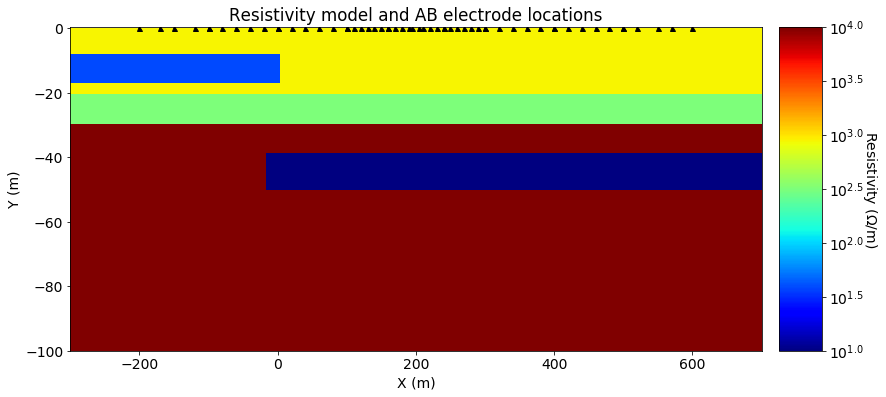

In [24]:
depth_to_clay = -20.
depth_to_bedrock = -30.

# Create layered model with background resistivities
resistivity_model = ModelBuilder.layeredModel(
    mesh.gridCC, np.r_[0., depth_to_clay, depth_to_bedrock], np.r_[alluvium_resistivity, clay_resistivity, bedrock_resistivity]
)
# Add the sand aquifer
ind = ModelBuilder.getIndicesBlock([-np.inf, -8.], [10, -16], mesh.gridCC)
resistivity_model[ind] = sand_aquifer_resistivity

# Add the bedrock aquifer
ind = ModelBuilder.getIndicesBlock([-10, -40.], [np.inf, -50], mesh.gridCC)
resistivity_model[ind] = bedrock_aquifer_resistivity

# Define a mapping from the model to the mesh
model_map = maps.IdentityMap(mesh)

# Plot the resistivity model
fig = plt.figure(figsize=(12, 5))
mpl.rcParams.update({'font.size': 14})

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
mesh.plotImage(
    np.log10(resistivity_model), ax=ax1, range_x=[-500+center_location, 500+center_location], range_y=[-100, 0.5], pcolorOpts={'cmap':'jet'}
)
ax1.set_title('Resistivity model and AB electrode locations')

# Add survey geometry
survey.getABMN_locations()
AB_locations = np.r_[
    survey.a_locations, survey.b_locations,
    ]
ax1.plot(AB_locations[:, 0], AB_locations[:, 1], 'k^', markersize=5)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')

# Add colorbar
ax2 = fig.add_axes([0.87, 0.05, 0.05, 0.9])
norm = mpl.colors.Normalize(
    vmin=np.floor(np.log10(np.min(resistivity_model))), vmax=np.ceil(np.log10(np.max(resistivity_model)))
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.jet, orientation='vertical', format="$10^{%.1f}$"
)
cbar.set_label(
    'Resistivity ($\Omega$/m)', rotation=270, labelpad=15, size=14
)

Run the Simulation
---------------------------

In this part of the notebook, all the pieces needed to predict the data are assembled into a *simulation*. Once created, we can predict data for a given *resistivity model*. We have chosen to predict the data as voltages. Once the data are predicted, we convert the values to apparent resistivities and plot the Schlumberger sounding curve.

In [25]:
simulation = dc.simulation_2d.Problem2D_N(
        mesh, survey=survey, rhoMap=model_map, Solver=Solver
        )

# Predict the data by running the simulation.
dpred = simulation.dpred(resistivity_model)

# Convert voltages to apparent resistivities
dpred = dpred/geometric_factor(survey)

Plot the Sounding Curve
-----------------------------------

Here, we plot the apparent resistivities as a function of AB/2 values. This produces a sounding curve which can be used to understand how the resistivity changes with respect to depth.

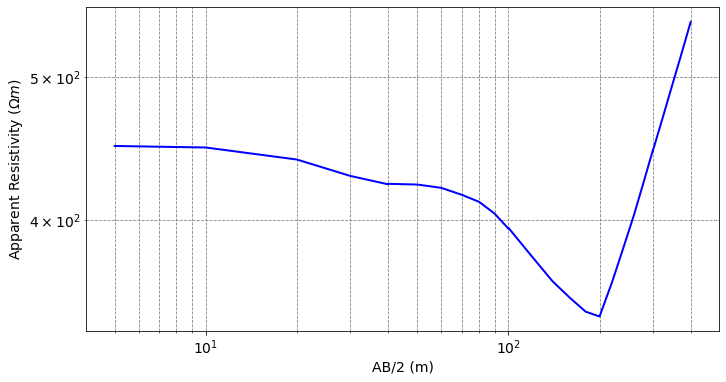

In [26]:
# Plot apparent resistivities on sounding curve
mpl.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
ax1.loglog(half_AB_separation, dpred, 'b', lw=2)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="--", c='gray') 
plt.show()

In [28]:
# Save the data to a CSV file
out_dat = np.c_[half_AB_separation, half_MN_separation, dpred]
columns = ['AB/2 (m)','MN/2 (m)','App. Res. (Ohm m)']
df = pd.DataFrame(out_dat, columns=columns)
df.to_csv(filename, index=False)